This notebook was used to compute the second gap and to build the Figures 6, 7, 8 and to estimate the phase transition.

In [ ]:
%pip install pennylane
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 67.6 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np

Functions to prepare the state and evolve it in the imaginary time.

In [ ]:
#Trotter for Ising
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]])
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]])
sigma_y = np.array([[0.0, -1j], [1j, 0.0]])
W = np.array([[1.0, -1j], [1.0, 1j]])/np.sqrt(2.)

def Ising_U(dt, J, h):
  """
  Returns the unitary matrix for the Ising Trotterization.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term.

  Returns:
     U - unitary matrix used in Trotter evolution on two neighbour sites.
  """
  H = -J*np.einsum("ij, kl -> ikjl", sigma_z, sigma_z)
  H -= h*np.einsum("ij, kl -> ikjl", sigma_x, np.eye(2))/2
  H -= h*np.einsum("ij, kl -> ikjl", np.eye(2), sigma_x)/2
  H = np.reshape(H, [4,4])
  d, V = np.linalg.eigh(H)
  U = np.einsum("ij, j, kj -> ik", V, np.exp(-1j*dt*d), V)
  return U

def Trotter_Ising(dt, J, h, wqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in real time.
  Note, that wqubits should be even.

  Args:
    dt (np.float): Trotter time step;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    wqubits (np.int) : number of physical (without ancilla) qubits

  """
  N = wqubits//2
  U = Ising_U(dt, J, h)
  for q in range(N):
    qml.QubitUnitary(U, wires = [2*q,2*q+1])
  for q in range(N-1):
    qml.QubitUnitary(U, wires = [2*q+1,2*q+2])
  qml.QubitUnitary(U, wires = [wqubits-1, 0])


@qml.defer_measurements
def imaginary_time_step_Ising(dt, J, h, nqubits, theta0):
  """
  Applies one step of Trotterized evolution with Ising Hamiltonian in imaginery time.
  Note, that wqubits should be even.

  Args:
    dt (np.float): Trotter time step of real time evolution;
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    theta0 (np.float): the angle of the Rz gate, as defined in arXiv:2111.12471
  """
  wqubits = nqubits - 1
  qml.Hadamard(wires = [nqubits-1])
  qml.QubitUnitary(W, wires = [nqubits-1])
  qml.ctrl(Trotter_Ising, [nqubits-1], control_values = [0])(dt, J, h, wqubits)
  qml.ctrl(qml.adjoint(Trotter_Ising), [nqubits-1], control_values = [1])(dt, J, h, wqubits)
  qml.RZ(-2*theta0, wires = [nqubits-1])
  qml.adjoint(qml.QubitUnitary(W, wires = [nqubits-1]))
  qml.measure(wires = [nqubits-1], postselect = 0)

def imaginary_time_evolution_Ising(steps, m0, J, h, nqubits):
  """
  Applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
  """
  s = m0/np.sqrt(1-m0**2)
  dtau = steps*s
  kappa = np.sign(m0 - 1./np.sqrt(2))
  theta0 = kappa*np.arccos((m0 + np.sqrt(1-m0**2))/np.sqrt(2))

  for c in range(len(steps)):
    dt = dtau[c]
    imaginary_time_step_Ising(dt, J, h, nqubits, theta0)

def state_prep(nqubits):
  """
  Prepares the initial product state.
  The state is prepared to have positive parity with respect to Z2 spin symmetry.
  """
  wqubits = nqubits - 1
  phi_init = 0.3
  for q in range(wqubits):
    # qml.PauliX(wires = [q])
    qml.Hadamard(wires = [q])
    # qml.RY(phi_init, wires = [q])


#Trotter for XXZ

In [ ]:
Nqubits = 11        #Number of qubits.
#Note, that one qubit is ancilla. Hence, the physical model is defined in
#Nqubits-1 qubits.
dev = qml.device("default.qubit", wires=Nqubits)

Functions for the imaginery time evolution, computation of energy, magnetization, and for subsequent gap estimation. We initialize here the state to be $Z_{2}$ symmetric and also use $ O = \sigma_{i}^{z} \sigma_{i+1}^{y}$ operator for the second gap extraction.

In [ ]:
@qml.qnode(dev)
def test_circuit(steps, m0, J, h, nqubits):
  '''
  Prepares the state, applies Trotterized evolution with Ising Hamiltonian in imaginery time.
  steps controls the Trotter time steps.
  Note, that nqubits should be odd.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    density_matrix - density matrix of the system on the physical qubits.
  '''
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, nqubits)
  return qml.density_matrix(wires = range(nqubits-1))

@qml.qnode(dev)
def test_energy(steps, m0, J, h, nqubits):
  """
  Finds the ground state energy with imaginary time evolution.
  Prepares the state and Hamiltonian. Evolves the state in imaginary time.
  Measures the Hamiltonian.

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.

  Returns:
    expval(H) - expectation value of the Ising Hamiltonian.
  """
  ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(nqubits-1)) for i in range(nqubits-1)]
  ZZ_coeff = [-J for i in range(nqubits-1)]
  X = [qml.PauliX(i) for i in range(nqubits-1)]
  X_coeff = [-h for i in range(nqubits-1)]

  obs = ZZ + X
  coeffs = ZZ_coeff + X_coeff
  H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  state_prep(nqubits)
  imaginary_time_evolution_Ising(steps, m0, J, h, nqubits)
  return qml.expval(H)


def gap_operators(steps, m0, J, h, nqubits):
  """
  Finds the [H,O] expectation value.
  Two such expectations for different imaginary times can be used to estimate
  the gap. (Operator O is defined in the text above)

  Args:
    steps (np.array): array of Trotter time steps for imaginary time evolution;
    m0 (np.float) : auxiliary number as defined in arXiv:2111.12471
    J (np.float) : the coefficient of the interaction term in the Ising Hamiltonian.
    h (np.float) : the coefficient of the transverse magnetic field term in X direction.
    nqubits (np.int): total number of qubits, both physical and one (last) ancilla qubit.
    k (np.int) : integer representation in range(L) of the quasimomentum sector.

  Returns:
    expt_HO - expectation value of the commutator [H,O] for the final time.
  """
  rdm = test_circuit(steps, m0, J, h, nqubits)
  obs = []
  coeffs = []
  for c in range(nqubits - 1):
    obs += [qml.PauliZ((c-1)%(nqubits-1))@qml.PauliZ(c), qml.PauliY((c-1)%(nqubits-1))@qml.PauliY(c), qml.PauliX(c), qml.PauliZ((c-1)%(nqubits-1))@qml.PauliX(c)@qml.PauliZ((c+1)%(nqubits-1))]
    coeffs += [-h, h, J, J]
  HO = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
  HOm = HO.sparse_matrix().todense()
  expt_HO = np.einsum("ij,ji ->", HOm, rdm)

  return expt_HO



Computation of the second gap with exact diagonalization:

In [ ]:

J = 1.0
h = 0.90
Nqubits = 11
ZZ = [qml.PauliZ(i)@qml.PauliZ((i+1)%(Nqubits-1)) for i in range(Nqubits-1)]
ZZ_coeff = [-J for i in range(Nqubits-1)]
X = [qml.PauliX(i) for i in range(Nqubits-1)]
X_coeff = [-h for i in range(Nqubits-1)]
X_coeff2 = [1.0 for i in range(Nqubits-1)]
obs = ZZ + X
coeffs = ZZ_coeff + X_coeff
# X2 = [qml.PauliX(0)@qml.PauliX(1)@qml.PauliX(2)@qml.PauliX(3)]
H = qml.Hamiltonian(coeffs, obs, grouping_type="qwc")
# H2 = qml.Hamiltonian([1.0],X2, grouping_type="qwc")
Hs = H.sparse_matrix()
M = Hs.todense()
# Hs2 = H2.sparse_matrix()
# S = Hs2.todense()


d, V = np.linalg.eigh(M)
# x = np.einsum("jk, ji, ik -> k", V, S, V)


# print(d)
# print(x)
print(f"First gap is {d[1] - d[0]}")
print(f"Second gap is {d[2] - d[0]}")

First gap is 0.0718071453156135
Second gap is 1.2528257383609223


Let us start computing the second gap. First we show that the commutator decays exponentially.

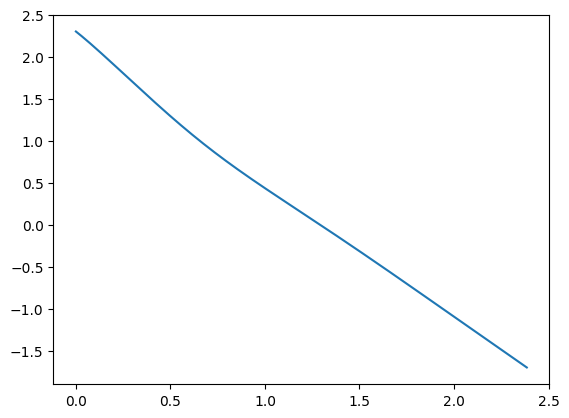

In [ ]:
step = 0.015
m0 = 0.8
gap_est = []
for nsteps in range(160):
  steps = step*np.ones(nsteps)
  est = gap_operators(steps, m0, J, h, Nqubits)
  gap_est.append(est)

plt.plot(step*np.arange(160), np.log(np.abs(gap_est)))

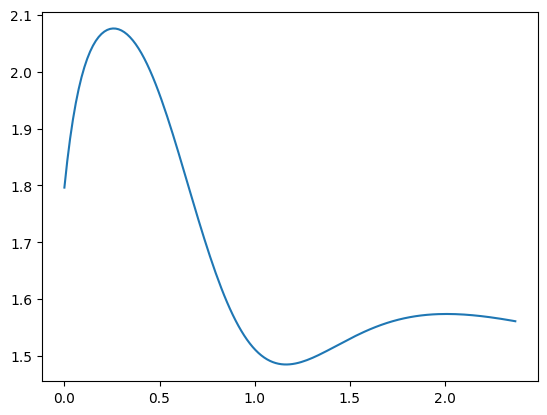

In [ ]:
plt.plot(step*np.arange(159), -np.diff(np.log(np.abs(gap_est))/step))

In [ ]:
nsteps = 220

step1 = 0.02       #Large time step for preliminary optimization
steps = step1*np.ones(nsteps)
est1 = gap_operators(steps, m0, J, h, Nqubits)

step2 = 0.002      #Small time step for gap extraction.
steps = np.append(steps, step2)
est2 = gap_operators(steps, m0, J, h, Nqubits)

gap1 = -np.log(np.abs(est2/est1))/step2

step1 = 0.02       #Large time step for preliminary optimization
steps = step1*np.ones(nsteps)
est1 = gap_operators(steps, m0, J, h, Nqubits)

step2 = 0.001      #Small time step for gap extraction.
steps = np.append(steps, step2)
est2 = gap_operators(steps, m0, J, h, Nqubits)

gap2 = -np.log(np.abs(est2/est1))/step2

gap_extrapolated = gap2 + (gap2 - gap1)


print(f"The gap estimation is {gap_extrapolated}")
print(f"Exact energy gap is: {d[2] -d[0]}")
print(f"The error is: {100*(d[2] -d[0]-gap_extrapolated)/gap_extrapolated} %")


The gap estimation is 2.2944285661672663
Exact energy gap is: 2.1870289754087597
The error is: -4.680886227716058 %


We can now estimate the second gap for a range of couplings $J$:

In [ ]:
nsteps = 180
##We have used only 120 steps at smaller Nqubits, as the gap was larger.
Second_gaps10 = []
hx = np.linspace(0.7, 1.1, num = 16)
for h in hx:
  step1 = 0.02       #Large time step for preliminary optimization
  steps = step1*np.ones(nsteps)
  est1 = gap_operators(steps, m0, J, h, Nqubits)

  step2 = 0.002      #Small time step for gap extraction.
  steps = np.append(steps, step2)
  est2 = gap_operators(steps, m0, J, h, Nqubits)

  gap1 = -np.log(np.abs(est2/est1))/step2

  step1 = 0.02       #Large time step for preliminary optimization
  steps = step1*np.ones(nsteps)
  est1 = gap_operators(steps, m0, J, h, Nqubits)

  step2 = 0.001      #Small time step for gap extraction.
  steps = np.append(steps, step2)
  est2 = gap_operators(steps, m0, J, h, Nqubits)

  gap2 = -np.log(np.abs(est2/est1))/step2

  gap_extrapolated = gap2 + (gap2 - gap1)

  print(f"Magnetic field h is {h}")
  print(f"The gap estimation is {gap_extrapolated}")
  # print(f"Exact energy gap is: {d[2] -d[0]}")
  # print(f"The error is: {100*(d[2] -d[0]-gap_extrapolated)/gap_extrapolated} %")

  Second_gaps10.append(gap_extrapolated)

Magnetic field h is 0.7
The gap estimation is 1.6868526243753297
Magnetic field h is 0.7266666666666667
The gap estimation is 1.6180511294849345
Magnetic field h is 0.7533333333333333
The gap estimation is 1.5556652122695105
Magnetic field h is 0.78
The gap estimation is 1.5007427953532868
Magnetic field h is 0.8066666666666666
The gap estimation is 1.454310342411217
Magnetic field h is 0.8333333333333334
The gap estimation is 1.4173049081707245
Magnetic field h is 0.86
The gap estimation is 1.3905102606465298
Magnetic field h is 0.8866666666666667
The gap estimation is 1.3745069520511914
Magnetic field h is 0.9133333333333333
The gap estimation is 1.369643355499636
Magnetic field h is 0.9400000000000001
The gap estimation is 1.3760302251394252
Magnetic field h is 0.9666666666666668
The gap estimation is 1.3935567585287119
Magnetic field h is 0.9933333333333334
The gap estimation is 1.4219227274429675
Magnetic field h is 1.02
The gap estimation is 1.4606796807669058
Magnetic field h is

In [ ]:
np.save("Second_gaps10.npy", Second_gaps10)

The plot below uses the data Second_gaps6, Second_gaps8. This data can be obtained with the code above, but with change of Nqubits to 7 and 9 respectively. Alternatively, this data is given in our submission files.  We have rerun the blocks of code above for these different numbers of qubits and plotted the full obtained data below. (Figure 6)

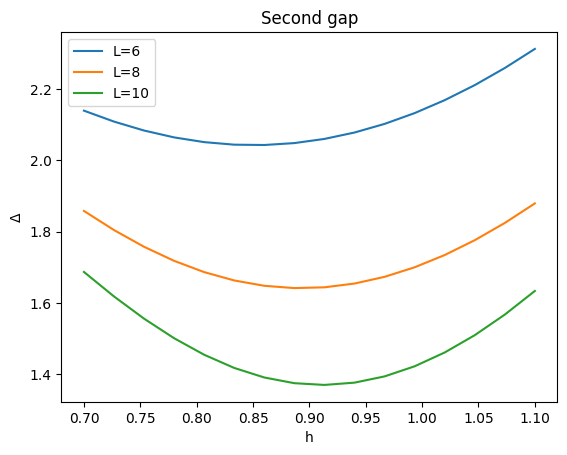

In [ ]:
plt.plot(hx, Second_gaps6, label = "L=6")
plt.plot(hx, Second_gaps8, label = "L=8")
plt.plot(hx, Second_gaps10, label = "L=10")
plt.legend()
plt.title("Second gap")
plt.xlabel("h")
plt.ylabel(r'$\Delta$')
plt.savefig("Second_gap.pdf")

The code below is use to estimate the phase transition using linear fit of data for different system sizes $L$. This results in two different plots below (Figure 7 and 8) and results in our estimates of the transition point.

In [ ]:
hcr = [hx[np.argmin(Second_gaps6)], hx[np.argmin(Second_gaps8)], hx[np.argmin(Second_gaps10)]]

In [ ]:
Lcr = np.array([6, 8, 10])

In [ ]:
Gap_min = [Second_gaps6[np.argmin(Second_gaps6)], Second_gaps8[np.argmin(Second_gaps8)], Second_gaps10[np.argmin(Second_gaps10)]]

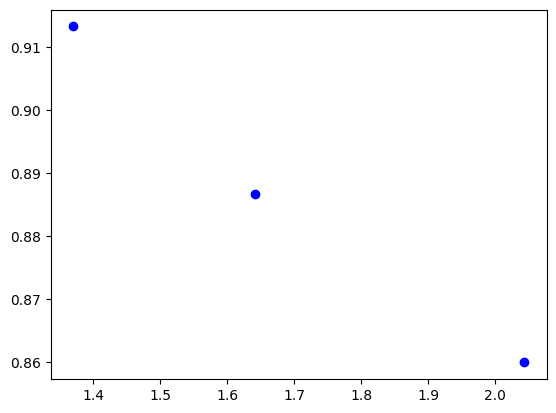

In [ ]:
plt.plot(Gap_min, hcr, 'bo')

In [ ]:
slope, intercept = np.linalg.lstsq(np.vstack([Gap_min, np.ones(len(Gap_min))]).T, hcr, rcond=None)[0]

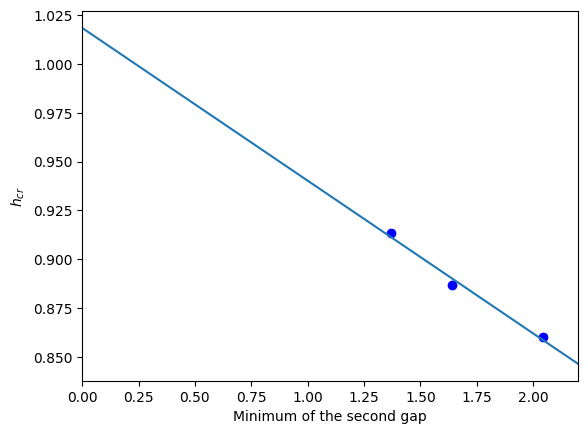

In [ ]:
plt.plot(Gap_min, hcr, 'bo')
plt.plot(np.linspace(0, 2.2, num = 23), slope*np.linspace(0, 2.2, num = 23)+intercept)
plt.xlabel("Minimum of the second gap")
plt.ylabel(r"$h_{cr}$")
plt.xlim(0, 2.2)
plt.savefig("First_fit.pdf")

In [ ]:
slope2, intercept2 = np.linalg.lstsq(np.vstack([1/Lcr, np.ones(len(Gap_min))]).T, hcr, rcond=None)[0]

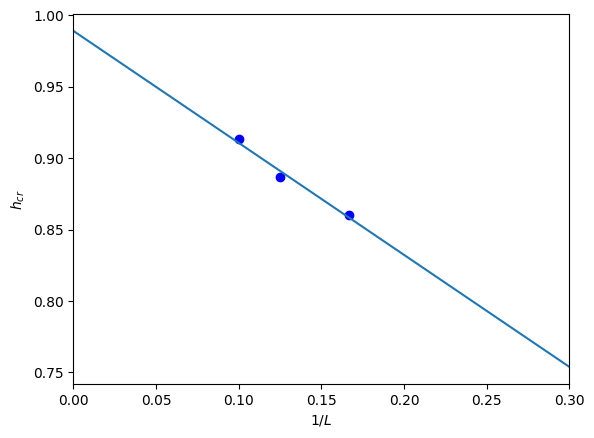

In [ ]:
plt.plot(1/Lcr, hcr, 'bo')
plt.plot(np.linspace(0, 0.3, num = 30), slope2*np.linspace(0, 0.3, num = 30)+intercept2)
plt.xlabel(r"$1/L$")
plt.ylabel(r"$h_{cr}$")
plt.xlim(0, 0.3)
plt.savefig("Second_fit.pdf")

Here are the estimates of the transition point obtained using the fits above.

In [ ]:
print(f"The first fit results in the critical value {intercept}")
print(f"The second fit results in the critical value {intercept2}")

The first fit results in the critical value 1.0184263488784602
The second fit results in the critical value 0.9889795918367343
